In [ ]:
!pip install transformers
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# configuration

max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

## Load the Data

In [ ]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  17.0M      0 --:--:-- --:--:-- --:--:-- 17.0M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [ ]:
# Only train on 100k samples
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

In [ ]:
# We have some NaN entries in our train data, we will simply drop them.
train_df.dropna(axis=0, inplace=True)

In [ ]:
# The value "-" appears as part of our training and validation targets.
# We will skip these samples.
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
test_df = (
    test_df[test_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [ ]:
# One-hot encode training, validation, and test labels.
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [ ]:
class DataGenerate(tf.keras.utils.Sequence):
    # Generates batches of data.
    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


In [ ]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f2d962256c0>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',        

In [ ]:
# create train and validation data generators
train_data = DataGenerate(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = DataGenerate(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
# train the Model
# done only for top layers for feature extraction
model_training = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=4,
    use_multiprocessing=True,
    workers=-1,
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/4
  33/3121 [..............................] - ETA: 16:01 - loss: 1.1175 - acc: 0.4138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 132/3121 [>.............................] - ETA: 15:55 - loss: 1.0451 - acc: 0.4645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 186/3121 [>.............................] - ETA: 15:42 - loss: 1.0215 - acc: 0.4891

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 198/3121 [>.............................] - ETA: 15:38 - loss: 1.0136 - acc: 0.4964

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 288/3121 [=>............................] - ETA: 15:02 - loss: 0.9737 - acc: 0.5269

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 304/3121 [=>............................] - ETA: 14:57 - loss: 0.9667 - acc: 0.5317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 305/3121 [=>............................] - ETA: 14:57 - loss: 0.9662 - acc: 0.5318

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 364/3121 [==>...........................] - ETA: 14:37 - loss: 0.9421 - acc: 0.5485

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 463/3121 [===>..........................] - ETA: 14:05 - loss: 0.9083 - acc: 0.5730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 548/3121 [====>.........................] - ETA: 13:38 - loss: 0.8902 - acc: 0.5859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 627/3121 [=====>........................] - ETA: 13:12 - loss: 0.8709 - acc: 0.5984

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 640/3121 [=====>........................] - ETA: 13:07 - loss: 0.8681 - acc: 0.6005

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 681/3121 [=====>........................] - ETA: 12:54 - loss: 0.8594 - acc: 0.6065

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 714/3121 [=====>........................] - ETA: 12:44 - loss: 0.8531 - acc: 0.6100

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 800/3121 [======>.......................] - ETA: 12:16 - loss: 0.8395 - acc: 0.6181

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 903/3121 [=======>......................] - ETA: 11:44 - loss: 0.8231 - acc: 0.6285

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 960/3121 [========>.....................] - ETA: 11:25 - loss: 0.8140 - acc: 0.6340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1013/3121 [========>.....................] - ETA: 11:08 - loss: 0.8079 - acc: 0.6380

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1048/3121 [=========>....................] - ETA: 10:57 - loss: 0.8022 - acc: 0.6415

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1054/3121 [=========>....................] - ETA: 10:55 - loss: 0.8019 - acc: 0.6417

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1063/3121 [=========>....................] - ETA: 10:52 - loss: 0.8012 - acc: 0.6421

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1225/3121 [==========>...................] - ETA: 10:01 - loss: 0.7832 - acc: 0.6530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1266/3121 [===========>..................] - ETA: 9:48 - loss: 0.7800 - acc: 0.6547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1279/3121 [===========>..................] - ETA: 9:44 - loss: 0.7783 - acc: 0.6557

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1319/3121 [===========>..................] - ETA: 9:31 - loss: 0.7747 - acc: 0.6582

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1326/3121 [===========>..................] - ETA: 9:29 - loss: 0.7743 - acc: 0.6586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1338/3121 [===========>..................] - ETA: 9:25 - loss: 0.7735 - acc: 0.6588

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1342/3121 [===========>..................] - ETA: 9:24 - loss: 0.7729 - acc: 0.6591

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1360/3121 [============>.................] - ETA: 9:18 - loss: 0.7717 - acc: 0.6600

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1376/3121 [============>.................] - ETA: 9:13 - loss: 0.7698 - acc: 0.6609

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1431/3121 [============>.................] - ETA: 8:55 - loss: 0.7663 - acc: 0.6632

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1454/3121 [============>.................] - ETA: 8:48 - loss: 0.7650 - acc: 0.6641

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1557/3121 [=============>................] - ETA: 8:15 - loss: 0.7592 - acc: 0.6679

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1564/3121 [==============>...............] - ETA: 8:13 - loss: 0.7589 - acc: 0.6679

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1568/3121 [==============>...............] - ETA: 8:12 - loss: 0.7587 - acc: 0.6680

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1571/3121 [==============>...............] - ETA: 8:11 - loss: 0.7584 - acc: 0.6681

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1578/3121 [==============>...............] - ETA: 8:09 - loss: 0.7578 - acc: 0.6685

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1615/3121 [==============>...............] - ETA: 7:57 - loss: 0.7556 - acc: 0.6699

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1831/3121 [================>.............] - ETA: 6:48 - loss: 0.7409 - acc: 0.6785

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1866/3121 [================>.............] - ETA: 6:37 - loss: 0.7393 - acc: 0.6797

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1897/3121 [=================>............] - ETA: 6:28 - loss: 0.7371 - acc: 0.6809

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1899/3121 [=================>............] - ETA: 6:27 - loss: 0.7370 - acc: 0.6809

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2049/3121 [==================>...........] - ETA: 5:39 - loss: 0.7293 - acc: 0.6852

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2078/3121 [==================>...........] - ETA: 5:30 - loss: 0.7287 - acc: 0.6858

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2094/3121 [===================>..........] - ETA: 5:25 - loss: 0.7277 - acc: 0.6864

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2100/3121 [===================>..........] - ETA: 5:23 - loss: 0.7273 - acc: 0.6867

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2124/3121 [===================>..........] - ETA: 5:16 - loss: 0.7259 - acc: 0.6874

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2155/3121 [===================>..........] - ETA: 5:06 - loss: 0.7244 - acc: 0.6883

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2163/3121 [===================>..........] - ETA: 5:03 - loss: 0.7241 - acc: 0.6883

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2200/3121 [====================>.........] - ETA: 4:51 - loss: 0.7226 - acc: 0.6892

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2233/3121 [====================>.........] - ETA: 4:41 - loss: 0.7209 - acc: 0.6901

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2237/3121 [====================>.........] - ETA: 4:40 - loss: 0.7209 - acc: 0.6902

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2258/3121 [====================>.........] - ETA: 4:33 - loss: 0.7201 - acc: 0.6907

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2293/3121 [=====================>........] - ETA: 4:22 - loss: 0.7185 - acc: 0.6913

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2380/3121 [=====================>........] - ETA: 3:54 - loss: 0.7155 - acc: 0.6932

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2428/3121 [======================>.......] - ETA: 3:39 - loss: 0.7134 - acc: 0.6943

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2468/3121 [======================>.......] - ETA: 3:26 - loss: 0.7125 - acc: 0.6950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2480/3121 [======================>.......] - ETA: 3:23 - loss: 0.7126 - acc: 0.6950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2513/3121 [=======================>......] - ETA: 3:12 - loss: 0.7120 - acc: 0.6954

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2590/3121 [=======================>......] - ETA: 2:48 - loss: 0.7094 - acc: 0.6968

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2616/3121 [========================>.....] - ETA: 2:40 - loss: 0.7090 - acc: 0.6972

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2653/3121 [========================>.....] - ETA: 2:28 - loss: 0.7078 - acc: 0.6979

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2657/3121 [========================>.....] - ETA: 2:27 - loss: 0.7077 - acc: 0.6979

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2682/3121 [========================>.....] - ETA: 2:19 - loss: 0.7070 - acc: 0.6983

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2696/3121 [========================>.....] - ETA: 2:14 - loss: 0.7065 - acc: 0.6987

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2724/3121 [=========================>....] - ETA: 2:05 - loss: 0.7056 - acc: 0.6991

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2816/3121 [==========================>...] - ETA: 1:36 - loss: 0.7027 - acc: 0.7007

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2841/3121 [==========================>...] - ETA: 1:28 - loss: 0.7017 - acc: 0.7012

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2862/3121 [==========================>...] - ETA: 1:22 - loss: 0.7011 - acc: 0.7016

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2895/3121 [==========================>...] - ETA: 1:11 - loss: 0.7004 - acc: 0.7019

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2928/3121 [===========================>..] - ETA: 1:01 - loss: 0.6992 - acc: 0.7025

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2935/3121 [===========================>..] - ETA: 58s - loss: 0.6990 - acc: 0.7027

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2965/3121 [===========================>..] - ETA: 49s - loss: 0.6985 - acc: 0.7031

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2986/3121 [===========================>..] - ETA: 42s - loss: 0.6978 - acc: 0.7035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2994/3121 [===========================>..] - ETA: 40s - loss: 0.6976 - acc: 0.7036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3048/3121 [============================>.] - ETA: 23s - loss: 0.6965 - acc: 0.7043

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3073/3121 [============================>.] - ETA: 15s - loss: 0.6959 - acc: 0.7047

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3091/3121 [============================>.] - ETA: 9s - loss: 0.6953 - acc: 0.7051

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.6952 - acc: 0.7052

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will alwa

3121/3121 [==============================] - 1104s 347ms/step - loss: 0.6952 - acc: 0.7052 - val_loss: 0.5321 - val_acc: 0.7932
Epoch 2/4
   9/3121 [..............................] - ETA: 16:21 - loss: 0.5604 - acc: 0.7743

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  51/3121 [..............................] - ETA: 16:08 - loss: 0.6040 - acc: 0.7543

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  70/3121 [..............................] - ETA: 16:06 - loss: 0.5925 - acc: 0.7585

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 142/3121 [>.............................] - ETA: 15:42 - loss: 0.6075 - acc: 0.7515

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 195/3121 [>.............................] - ETA: 15:26 - loss: 0.6024 - acc: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 207/3121 [>.............................] - ETA: 15:23 - loss: 0.6059 - acc: 0.7518

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 243/3121 [=>............................] - ETA: 15:11 - loss: 0.6088 - acc: 0.7496

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 353/3121 [==>...........................] - ETA: 14:36 - loss: 0.6029 - acc: 0.7530

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 591/3121 [====>.........................] - ETA: 13:21 - loss: 0.5943 - acc: 0.7563

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 732/3121 [======>.......................] - ETA: 12:36 - loss: 0.5936 - acc: 0.7565

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 752/3121 [======>.......................] - ETA: 12:30 - loss: 0.5936 - acc: 0.7571

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 895/3121 [=======>......................] - ETA: 11:44 - loss: 0.5952 - acc: 0.7556

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 922/3121 [=======>......................] - ETA: 11:36 - loss: 0.5953 - acc: 0.7552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1103/3121 [=========>....................] - ETA: 10:39 - loss: 0.5965 - acc: 0.7551

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1107/3121 [=========>....................] - ETA: 10:37 - loss: 0.5963 - acc: 0.7552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1144/3121 [=========>....................] - ETA: 10:26 - loss: 0.5960 - acc: 0.7556

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1156/3121 [==========>...................] - ETA: 10:22 - loss: 0.5963 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1209/3121 [==========>...................] - ETA: 10:05 - loss: 0.5962 - acc: 0.7556

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1217/3121 [==========>...................] - ETA: 10:02 - loss: 0.5960 - acc: 0.7559

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1306/3121 [===========>..................] - ETA: 9:34 - loss: 0.5959 - acc: 0.7563

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1316/3121 [===========>..................] - ETA: 9:31 - loss: 0.5958 - acc: 0.7565

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1325/3121 [===========>..................] - ETA: 9:28 - loss: 0.5961 - acc: 0.7563

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1332/3121 [===========>..................] - ETA: 9:26 - loss: 0.5960 - acc: 0.7561

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1395/3121 [============>.................] - ETA: 9:06 - loss: 0.5971 - acc: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1442/3121 [============>.................] - ETA: 8:51 - loss: 0.5960 - acc: 0.7560

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1468/3121 [=============>................] - ETA: 8:43 - loss: 0.5958 - acc: 0.7561

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1479/3121 [=============>................] - ETA: 8:40 - loss: 0.5948 - acc: 0.7566

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1502/3121 [=============>................] - ETA: 8:32 - loss: 0.5944 - acc: 0.7568

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1530/3121 [=============>................] - ETA: 8:23 - loss: 0.5942 - acc: 0.7570

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1551/3121 [=============>................] - ETA: 8:17 - loss: 0.5938 - acc: 0.7573

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1557/3121 [=============>................] - ETA: 8:15 - loss: 0.5939 - acc: 0.7572

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1584/3121 [==============>...............] - ETA: 8:06 - loss: 0.5930 - acc: 0.7577

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1595/3121 [==============>...............] - ETA: 8:03 - loss: 0.5930 - acc: 0.7579

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1640/3121 [==============>...............] - ETA: 7:49 - loss: 0.5921 - acc: 0.7586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1643/3121 [==============>...............] - ETA: 7:48 - loss: 0.5922 - acc: 0.7586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1708/3121 [===============>..............] - ETA: 7:27 - loss: 0.5931 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1752/3121 [===============>..............] - ETA: 7:13 - loss: 0.5938 - acc: 0.7577

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1792/3121 [================>.............] - ETA: 7:00 - loss: 0.5937 - acc: 0.7578

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1860/3121 [================>.............] - ETA: 6:39 - loss: 0.5931 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1862/3121 [================>.............] - ETA: 6:38 - loss: 0.5932 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1889/3121 [=================>............] - ETA: 6:30 - loss: 0.5934 - acc: 0.7578

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1891/3121 [=================>............] - ETA: 6:29 - loss: 0.5936 - acc: 0.7577

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1918/3121 [=================>............] - ETA: 6:21 - loss: 0.5938 - acc: 0.7576

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1930/3121 [=================>............] - ETA: 6:17 - loss: 0.5939 - acc: 0.7574

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1953/3121 [=================>............] - ETA: 6:09 - loss: 0.5939 - acc: 0.7575

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2020/3121 [==================>...........] - ETA: 5:48 - loss: 0.5931 - acc: 0.7578

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2061/3121 [==================>...........] - ETA: 5:35 - loss: 0.5931 - acc: 0.7577

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2074/3121 [==================>...........] - ETA: 5:31 - loss: 0.5933 - acc: 0.7576

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2112/3121 [===================>..........] - ETA: 5:19 - loss: 0.5928 - acc: 0.7578

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2160/3121 [===================>..........] - ETA: 5:04 - loss: 0.5925 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2188/3121 [====================>.........] - ETA: 4:55 - loss: 0.5932 - acc: 0.7576

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2203/3121 [====================>.........] - ETA: 4:50 - loss: 0.5928 - acc: 0.7578

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2246/3121 [====================>.........] - ETA: 4:37 - loss: 0.5930 - acc: 0.7579

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2261/3121 [====================>.........] - ETA: 4:32 - loss: 0.5929 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2282/3121 [====================>.........] - ETA: 4:25 - loss: 0.5931 - acc: 0.7579

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2291/3121 [=====================>........] - ETA: 4:22 - loss: 0.5929 - acc: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2310/3121 [=====================>........] - ETA: 4:16 - loss: 0.5926 - acc: 0.7582

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2322/3121 [=====================>........] - ETA: 4:13 - loss: 0.5930 - acc: 0.7579

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2394/3121 [======================>.......] - ETA: 3:50 - loss: 0.5930 - acc: 0.7581

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2453/3121 [======================>.......] - ETA: 3:31 - loss: 0.5925 - acc: 0.7583

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2468/3121 [======================>.......] - ETA: 3:26 - loss: 0.5925 - acc: 0.7582

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2564/3121 [=======================>......] - ETA: 2:56 - loss: 0.5924 - acc: 0.7584

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2565/3121 [=======================>......] - ETA: 2:56 - loss: 0.5924 - acc: 0.7584

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2587/3121 [=======================>......] - ETA: 2:49 - loss: 0.5921 - acc: 0.7583

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2620/3121 [========================>.....] - ETA: 2:38 - loss: 0.5920 - acc: 0.7583

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2707/3121 [=========================>....] - ETA: 2:11 - loss: 0.5916 - acc: 0.7588

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2716/3121 [=========================>....] - ETA: 2:08 - loss: 0.5917 - acc: 0.7587

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2728/3121 [=========================>....] - ETA: 2:04 - loss: 0.5916 - acc: 0.7587

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2747/3121 [=========================>....] - ETA: 1:58 - loss: 0.5915 - acc: 0.7588

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2763/3121 [=========================>....] - ETA: 1:53 - loss: 0.5916 - acc: 0.7587

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2825/3121 [==========================>...] - ETA: 1:33 - loss: 0.5909 - acc: 0.7589

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2843/3121 [==========================>...] - ETA: 1:28 - loss: 0.5910 - acc: 0.7589

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2899/3121 [==========================>...] - ETA: 1:10 - loss: 0.5907 - acc: 0.7592

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2920/3121 [===========================>..] - ETA: 1:03 - loss: 0.5907 - acc: 0.7593

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2921/3121 [===========================>..] - ETA: 1:03 - loss: 0.5907 - acc: 0.7593

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2950/3121 [===========================>..] - ETA: 54s - loss: 0.5901 - acc: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3043/3121 [============================>.] - ETA: 24s - loss: 0.5906 - acc: 0.7594

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.5906 - acc: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 1078s 345ms/step - loss: 0.5906 - acc: 0.7595 - val_loss: 0.4915 - val_acc: 0.8059
Epoch 3/4
  46/3121 [..............................] - ETA: 16:18 - loss: 0.5685 - acc: 0.7656

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  64/3121 [..............................] - ETA: 16:13 - loss: 0.5542 - acc: 0.7754

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 130/3121 [>.............................] - ETA: 15:51 - loss: 0.5609 - acc: 0.7728

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 157/3121 [>.............................] - ETA: 15:40 - loss: 0.5641 - acc: 0.7701

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 175/3121 [>.............................] - ETA: 15:35 - loss: 0.5671 - acc: 0.7680

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 176/3121 [>.............................] - ETA: 15:35 - loss: 0.5666 - acc: 0.7688

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 197/3121 [>.............................] - ETA: 15:27 - loss: 0.5682 - acc: 0.7692

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 298/3121 [=>............................] - ETA: 14:55 - loss: 0.5742 - acc: 0.7670

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 358/3121 [==>...........................] - ETA: 14:36 - loss: 0.5707 - acc: 0.7692

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 459/3121 [===>..........................] - ETA: 14:03 - loss: 0.5660 - acc: 0.7716

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 472/3121 [===>..........................] - ETA: 13:59 - loss: 0.5669 - acc: 0.7717

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 509/3121 [===>..........................] - ETA: 13:47 - loss: 0.5640 - acc: 0.7731

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 516/3121 [===>..........................] - ETA: 13:45 - loss: 0.5630 - acc: 0.7736

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 577/3121 [====>.........................] - ETA: 13:26 - loss: 0.5631 - acc: 0.7744

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 662/3121 [=====>........................] - ETA: 12:59 - loss: 0.5630 - acc: 0.7731

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 669/3121 [=====>........................] - ETA: 12:57 - loss: 0.5630 - acc: 0.7730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 735/3121 [======>.......................] - ETA: 12:36 - loss: 0.5626 - acc: 0.7730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 788/3121 [======>.......................] - ETA: 12:19 - loss: 0.5630 - acc: 0.7724

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 821/3121 [======>.......................] - ETA: 12:09 - loss: 0.5645 - acc: 0.7718

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 836/3121 [=======>......................] - ETA: 12:04 - loss: 0.5652 - acc: 0.7714

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 843/3121 [=======>......................] - ETA: 12:01 - loss: 0.5656 - acc: 0.7711

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 852/3121 [=======>......................] - ETA: 11:58 - loss: 0.5655 - acc: 0.7715

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 857/3121 [=======>......................] - ETA: 11:57 - loss: 0.5656 - acc: 0.7715

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 929/3121 [=======>......................] - ETA: 11:34 - loss: 0.5644 - acc: 0.7725

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 977/3121 [========>.....................] - ETA: 11:19 - loss: 0.5640 - acc: 0.7722

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 997/3121 [========>.....................] - ETA: 11:13 - loss: 0.5633 - acc: 0.7729

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1001/3121 [========>.....................] - ETA: 11:12 - loss: 0.5634 - acc: 0.7728

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1179/3121 [==========>...................] - ETA: 10:15 - loss: 0.5646 - acc: 0.7725

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1194/3121 [==========>...................] - ETA: 10:11 - loss: 0.5644 - acc: 0.7727

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1225/3121 [==========>...................] - ETA: 10:01 - loss: 0.5644 - acc: 0.7727

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1239/3121 [==========>...................] - ETA: 9:57 - loss: 0.5645 - acc: 0.7728

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1261/3121 [===========>..................] - ETA: 9:49 - loss: 0.5641 - acc: 0.7731

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1299/3121 [===========>..................] - ETA: 9:37 - loss: 0.5635 - acc: 0.7735

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1335/3121 [===========>..................] - ETA: 9:26 - loss: 0.5627 - acc: 0.7736

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1355/3121 [============>.................] - ETA: 9:20 - loss: 0.5626 - acc: 0.7738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1363/3121 [============>.................] - ETA: 9:17 - loss: 0.5629 - acc: 0.7735

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1387/3121 [============>.................] - ETA: 9:10 - loss: 0.5634 - acc: 0.7733

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1428/3121 [============>.................] - ETA: 8:57 - loss: 0.5638 - acc: 0.7730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1479/3121 [=============>................] - ETA: 8:40 - loss: 0.5635 - acc: 0.7733

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1533/3121 [=============>................] - ETA: 8:23 - loss: 0.5636 - acc: 0.7732

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1607/3121 [==============>...............] - ETA: 8:00 - loss: 0.5641 - acc: 0.7730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1637/3121 [==============>...............] - ETA: 7:50 - loss: 0.5643 - acc: 0.7732

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1794/3121 [================>.............] - ETA: 7:00 - loss: 0.5639 - acc: 0.7739

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1850/3121 [================>.............] - ETA: 6:43 - loss: 0.5646 - acc: 0.7736

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1885/3121 [=================>............] - ETA: 6:32 - loss: 0.5635 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1933/3121 [=================>............] - ETA: 6:16 - loss: 0.5629 - acc: 0.7741

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1947/3121 [=================>............] - ETA: 6:12 - loss: 0.5630 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2115/3121 [===================>..........] - ETA: 5:19 - loss: 0.5628 - acc: 0.7738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2150/3121 [===================>..........] - ETA: 5:08 - loss: 0.5628 - acc: 0.7739

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2181/3121 [===================>..........] - ETA: 4:58 - loss: 0.5630 - acc: 0.7738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2182/3121 [===================>..........] - ETA: 4:57 - loss: 0.5630 - acc: 0.7737

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2236/3121 [====================>.........] - ETA: 4:40 - loss: 0.5630 - acc: 0.7739

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2285/3121 [====================>.........] - ETA: 4:25 - loss: 0.5633 - acc: 0.7739

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2382/3121 [=====================>........] - ETA: 3:54 - loss: 0.5628 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2398/3121 [======================>.......] - ETA: 3:49 - loss: 0.5626 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2408/3121 [======================>.......] - ETA: 3:46 - loss: 0.5626 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2424/3121 [======================>.......] - ETA: 3:41 - loss: 0.5626 - acc: 0.7741

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2453/3121 [======================>.......] - ETA: 3:31 - loss: 0.5626 - acc: 0.7741

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2466/3121 [======================>.......] - ETA: 3:27 - loss: 0.5628 - acc: 0.7738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2472/3121 [======================>.......] - ETA: 3:25 - loss: 0.5628 - acc: 0.7738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2511/3121 [=======================>......] - ETA: 3:13 - loss: 0.5625 - acc: 0.7738

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2531/3121 [=======================>......] - ETA: 3:07 - loss: 0.5619 - acc: 0.7741

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2538/3121 [=======================>......] - ETA: 3:04 - loss: 0.5619 - acc: 0.7741

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2550/3121 [=======================>......] - ETA: 3:01 - loss: 0.5619 - acc: 0.7740

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2578/3121 [=======================>......] - ETA: 2:52 - loss: 0.5616 - acc: 0.7742

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2589/3121 [=======================>......] - ETA: 2:48 - loss: 0.5615 - acc: 0.7743

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2659/3121 [========================>.....] - ETA: 2:26 - loss: 0.5612 - acc: 0.7744

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2672/3121 [========================>.....] - ETA: 2:22 - loss: 0.5612 - acc: 0.7744

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2689/3121 [========================>.....] - ETA: 2:17 - loss: 0.5615 - acc: 0.7742

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2721/3121 [=========================>....] - ETA: 2:06 - loss: 0.5614 - acc: 0.7744

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2754/3121 [=========================>....] - ETA: 1:56 - loss: 0.5610 - acc: 0.7746

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2763/3121 [=========================>....] - ETA: 1:53 - loss: 0.5608 - acc: 0.7746

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2845/3121 [==========================>...] - ETA: 1:27 - loss: 0.5604 - acc: 0.7747

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2887/3121 [==========================>...] - ETA: 1:14 - loss: 0.5603 - acc: 0.7748

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2910/3121 [==========================>...] - ETA: 1:06 - loss: 0.5601 - acc: 0.7750

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2943/3121 [===========================>..] - ETA: 56s - loss: 0.5600 - acc: 0.7749

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3094/3121 [============================>.] - ETA: 8s - loss: 0.5593 - acc: 0.7749

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3104/3121 [============================>.] - ETA: 5s - loss: 0.5593 - acc: 0.7749

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3113/3121 [============================>.] - ETA: 2s - loss: 0.5592 - acc: 0.7750

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.5592 - acc: 0.7749

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 1080s 346ms/step - loss: 0.5592 - acc: 0.7749 - val_loss: 0.4818 - val_acc: 0.8120
Epoch 4/4
  80/3121 [..............................] - ETA: 16:08 - loss: 0.5328 - acc: 0.7973

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 119/3121 [>.............................] - ETA: 15:55 - loss: 0.5362 - acc: 0.7920

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 122/3121 [>.............................] - ETA: 15:54 - loss: 0.5385 - acc: 0.7925

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 138/3121 [>.............................] - ETA: 15:46 - loss: 0.5403 - acc: 0.7885

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 178/3121 [>.............................] - ETA: 15:35 - loss: 0.5374 - acc: 0.7900

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 227/3121 [=>............................] - ETA: 15:18 - loss: 0.5422 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 270/3121 [=>............................] - ETA: 15:05 - loss: 0.5392 - acc: 0.7870

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 293/3121 [=>............................] - ETA: 14:57 - loss: 0.5372 - acc: 0.7875

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 305/3121 [=>............................] - ETA: 14:54 - loss: 0.5378 - acc: 0.7862

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 339/3121 [==>...........................] - ETA: 14:42 - loss: 0.5379 - acc: 0.7865

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 373/3121 [==>...........................] - ETA: 14:32 - loss: 0.5377 - acc: 0.7859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 382/3121 [==>...........................] - ETA: 14:29 - loss: 0.5392 - acc: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 432/3121 [===>..........................] - ETA: 14:13 - loss: 0.5393 - acc: 0.7855

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 515/3121 [===>..........................] - ETA: 13:47 - loss: 0.5426 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 531/3121 [====>.........................] - ETA: 13:42 - loss: 0.5419 - acc: 0.7844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 613/3121 [====>.........................] - ETA: 13:16 - loss: 0.5425 - acc: 0.7831

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 614/3121 [====>.........................] - ETA: 13:16 - loss: 0.5423 - acc: 0.7833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 615/3121 [====>.........................] - ETA: 13:15 - loss: 0.5421 - acc: 0.7833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 630/3121 [=====>........................] - ETA: 13:11 - loss: 0.5417 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 634/3121 [=====>........................] - ETA: 13:10 - loss: 0.5417 - acc: 0.7833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 670/3121 [=====>........................] - ETA: 12:58 - loss: 0.5419 - acc: 0.7828

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 683/3121 [=====>........................] - ETA: 12:54 - loss: 0.5419 - acc: 0.7824

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 688/3121 [=====>........................] - ETA: 12:53 - loss: 0.5424 - acc: 0.7825

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 829/3121 [======>.......................] - ETA: 12:08 - loss: 0.5441 - acc: 0.7809

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 841/3121 [=======>......................] - ETA: 12:04 - loss: 0.5437 - acc: 0.7810

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 850/3121 [=======>......................] - ETA: 12:01 - loss: 0.5441 - acc: 0.7809

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 933/3121 [=======>......................] - ETA: 11:34 - loss: 0.5435 - acc: 0.7816

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 956/3121 [========>.....................] - ETA: 11:27 - loss: 0.5432 - acc: 0.7818

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1037/3121 [========>.....................] - ETA: 11:01 - loss: 0.5434 - acc: 0.7821

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1057/3121 [=========>....................] - ETA: 10:55 - loss: 0.5427 - acc: 0.7824

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1111/3121 [=========>....................] - ETA: 10:38 - loss: 0.5430 - acc: 0.7825

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1227/3121 [==========>...................] - ETA: 10:01 - loss: 0.5394 - acc: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1246/3121 [==========>...................] - ETA: 9:55 - loss: 0.5394 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1252/3121 [===========>..................] - ETA: 9:53 - loss: 0.5402 - acc: 0.7838

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1257/3121 [===========>..................] - ETA: 9:52 - loss: 0.5399 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1329/3121 [===========>..................] - ETA: 9:29 - loss: 0.5393 - acc: 0.7840

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1339/3121 [===========>..................] - ETA: 9:26 - loss: 0.5398 - acc: 0.7837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1372/3121 [============>.................] - ETA: 9:15 - loss: 0.5405 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1447/3121 [============>.................] - ETA: 8:51 - loss: 0.5414 - acc: 0.7830

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1466/3121 [=============>................] - ETA: 8:45 - loss: 0.5415 - acc: 0.7833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1572/3121 [==============>...............] - ETA: 8:12 - loss: 0.5420 - acc: 0.7834

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1608/3121 [==============>...............] - ETA: 8:00 - loss: 0.5423 - acc: 0.7833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1652/3121 [==============>...............] - ETA: 7:46 - loss: 0.5419 - acc: 0.7837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1695/3121 [===============>..............] - ETA: 7:33 - loss: 0.5419 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1715/3121 [===============>..............] - ETA: 7:26 - loss: 0.5422 - acc: 0.7834

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1782/3121 [================>.............] - ETA: 7:05 - loss: 0.5416 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1806/3121 [================>.............] - ETA: 6:57 - loss: 0.5411 - acc: 0.7836

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1884/3121 [=================>............] - ETA: 6:33 - loss: 0.5403 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1901/3121 [=================>............] - ETA: 6:27 - loss: 0.5403 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1983/3121 [==================>...........] - ETA: 6:01 - loss: 0.5396 - acc: 0.7838

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1985/3121 [==================>...........] - ETA: 6:00 - loss: 0.5397 - acc: 0.7837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1993/3121 [==================>...........] - ETA: 5:58 - loss: 0.5399 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2071/3121 [==================>...........] - ETA: 5:33 - loss: 0.5402 - acc: 0.7833

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2163/3121 [===================>..........] - ETA: 5:04 - loss: 0.5394 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2176/3121 [===================>..........] - ETA: 5:00 - loss: 0.5394 - acc: 0.7838

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2304/3121 [=====================>........] - ETA: 4:19 - loss: 0.5398 - acc: 0.7837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2349/3121 [=====================>........] - ETA: 4:05 - loss: 0.5393 - acc: 0.7841

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2407/3121 [======================>.......] - ETA: 3:46 - loss: 0.5390 - acc: 0.7843

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2445/3121 [======================>.......] - ETA: 3:34 - loss: 0.5393 - acc: 0.7842

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2491/3121 [======================>.......] - ETA: 3:20 - loss: 0.5397 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2529/3121 [=======================>......] - ETA: 3:08 - loss: 0.5399 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2554/3121 [=======================>......] - ETA: 3:00 - loss: 0.5401 - acc: 0.7837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2592/3121 [=======================>......] - ETA: 2:48 - loss: 0.5398 - acc: 0.7838

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2692/3121 [========================>.....] - ETA: 2:16 - loss: 0.5394 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2701/3121 [========================>.....] - ETA: 2:13 - loss: 0.5395 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2737/3121 [=========================>....] - ETA: 2:02 - loss: 0.5393 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2771/3121 [=========================>....] - ETA: 1:51 - loss: 0.5392 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2793/3121 [=========================>....] - ETA: 1:44 - loss: 0.5392 - acc: 0.7839

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2801/3121 [=========================>....] - ETA: 1:41 - loss: 0.5391 - acc: 0.7838

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2812/3121 [==========================>...] - ETA: 1:38 - loss: 0.5393 - acc: 0.7838

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2839/3121 [==========================>...] - ETA: 1:29 - loss: 0.5393 - acc: 0.7837

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2989/3121 [===========================>..] - ETA: 41s - loss: 0.5395 - acc: 0.7834

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2994/3121 [===========================>..] - ETA: 40s - loss: 0.5395 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3002/3121 [===========================>..] - ETA: 37s - loss: 0.5394 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3008/3121 [===========================>..] - ETA: 35s - loss: 0.5392 - acc: 0.7836

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3017/3121 [============================>.] - ETA: 33s - loss: 0.5394 - acc: 0.7835

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3036/3121 [============================>.] - ETA: 27s - loss: 0.5395 - acc: 0.7834

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3058/3121 [============================>.] - ETA: 20s - loss: 0.5393 - acc: 0.7836

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3110/3121 [============================>.] - ETA: 3s - loss: 0.5399 - acc: 0.7834

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.5400 - acc: 0.7834

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 1081s 346ms/step - loss: 0.5400 - acc: 0.7834 - val_loss: 0.4727 - val_acc: 0.8197


In [ ]:
# Unfreeze the bert_model
# fine tuning
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
# train again
model_training = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=2,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/2


  22/3121 [..............................] - ETA: 44:43 - loss: 0.5512 - accuracy: 0.7827

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  37/3121 [..............................] - ETA: 45:06 - loss: 0.5272 - accuracy: 0.7965

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  40/3121 [..............................] - ETA: 45:03 - loss: 0.5338 - accuracy: 0.7937

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  43/3121 [..............................] - ETA: 44:58 - loss: 0.5385 - accuracy: 0.7892

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  71/3121 [..............................] - ETA: 43:52 - loss: 0.5171 - accuracy: 0.8024

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  92/3121 [..............................] - ETA: 43:09 - loss: 0.5204 - accuracy: 0.8033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 101/3121 [..............................] - ETA: 42:57 - loss: 0.5157 - accuracy: 0.8029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 113/3121 [>.............................] - ETA: 42:44 - loss: 0.5154 - accuracy: 0.8017

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 147/3121 [>.............................] - ETA: 42:17 - loss: 0.5113 - accuracy: 0.8021

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 186/3121 [>.............................] - ETA: 41:39 - loss: 0.5109 - accuracy: 0.8023

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 280/3121 [=>............................] - ETA: 40:16 - loss: 0.5088 - accuracy: 0.8003

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 391/3121 [==>...........................] - ETA: 38:39 - loss: 0.5011 - accuracy: 0.8022

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 404/3121 [==>...........................] - ETA: 38:28 - loss: 0.5002 - accuracy: 0.8024

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 444/3121 [===>..........................] - ETA: 37:53 - loss: 0.4989 - accuracy: 0.8022

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 457/3121 [===>..........................] - ETA: 37:41 - loss: 0.4978 - accuracy: 0.8029

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 462/3121 [===>..........................] - ETA: 37:37 - loss: 0.4980 - accuracy: 0.8028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 486/3121 [===>..........................] - ETA: 37:16 - loss: 0.4973 - accuracy: 0.8033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 487/3121 [===>..........................] - ETA: 37:15 - loss: 0.4974 - accuracy: 0.8033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 493/3121 [===>..........................] - ETA: 37:10 - loss: 0.4965 - accuracy: 0.8036

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 577/3121 [====>.........................] - ETA: 35:58 - loss: 0.4920 - accuracy: 0.8056

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 610/3121 [====>.........................] - ETA: 35:29 - loss: 0.4901 - accuracy: 0.8070

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 644/3121 [=====>........................] - ETA: 35:00 - loss: 0.4894 - accuracy: 0.8075

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 698/3121 [=====>........................] - ETA: 34:14 - loss: 0.4860 - accuracy: 0.8098

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 707/3121 [=====>........................] - ETA: 34:07 - loss: 0.4859 - accuracy: 0.8098

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 713/3121 [=====>........................] - ETA: 34:01 - loss: 0.4852 - accuracy: 0.8103

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 800/3121 [======>.......................] - ETA: 32:48 - loss: 0.4837 - accuracy: 0.8111

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 820/3121 [======>.......................] - ETA: 32:31 - loss: 0.4843 - accuracy: 0.8112

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 888/3121 [=======>......................] - ETA: 31:33 - loss: 0.4836 - accuracy: 0.8119

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 957/3121 [========>.....................] - ETA: 30:34 - loss: 0.4819 - accuracy: 0.8124

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1029/3121 [========>.....................] - ETA: 29:33 - loss: 0.4789 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1080/3121 [=========>....................] - ETA: 28:50 - loss: 0.4776 - accuracy: 0.8139

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1150/3121 [==========>...................] - ETA: 27:50 - loss: 0.4756 - accuracy: 0.8152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1258/3121 [===========>..................] - ETA: 26:18 - loss: 0.4741 - accuracy: 0.8155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1259/3121 [===========>..................] - ETA: 26:18 - loss: 0.4741 - accuracy: 0.8155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1289/3121 [===========>..................] - ETA: 25:52 - loss: 0.4743 - accuracy: 0.8155

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1367/3121 [============>.................] - ETA: 24:46 - loss: 0.4739 - accuracy: 0.8156

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1468/3121 [=============>................] - ETA: 23:21 - loss: 0.4739 - accuracy: 0.8152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1520/3121 [=============>................] - ETA: 22:37 - loss: 0.4734 - accuracy: 0.8154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1527/3121 [=============>................] - ETA: 22:31 - loss: 0.4730 - accuracy: 0.8154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1627/3121 [==============>...............] - ETA: 21:06 - loss: 0.4710 - accuracy: 0.8161

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1635/3121 [==============>...............] - ETA: 20:59 - loss: 0.4708 - accuracy: 0.8162

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1764/3121 [===============>..............] - ETA: 19:10 - loss: 0.4700 - accuracy: 0.8169

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1820/3121 [================>.............] - ETA: 18:22 - loss: 0.4691 - accuracy: 0.8173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1832/3121 [================>.............] - ETA: 18:12 - loss: 0.4692 - accuracy: 0.8173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1840/3121 [================>.............] - ETA: 18:05 - loss: 0.4691 - accuracy: 0.8173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1851/3121 [================>.............] - ETA: 17:56 - loss: 0.4684 - accuracy: 0.8176

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1908/3121 [=================>............] - ETA: 17:07 - loss: 0.4675 - accuracy: 0.8181

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1917/3121 [=================>............] - ETA: 17:00 - loss: 0.4674 - accuracy: 0.8183

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1924/3121 [=================>............] - ETA: 16:54 - loss: 0.4672 - accuracy: 0.8184

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1944/3121 [=================>............] - ETA: 16:37 - loss: 0.4668 - accuracy: 0.8186

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1946/3121 [=================>............] - ETA: 16:35 - loss: 0.4669 - accuracy: 0.8185

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1964/3121 [=================>............] - ETA: 16:20 - loss: 0.4668 - accuracy: 0.8186

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2142/3121 [===================>..........] - ETA: 13:49 - loss: 0.4638 - accuracy: 0.8197

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2169/3121 [===================>..........] - ETA: 13:26 - loss: 0.4631 - accuracy: 0.8199

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2192/3121 [====================>.........] - ETA: 13:07 - loss: 0.4628 - accuracy: 0.8202

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2259/3121 [====================>.........] - ETA: 12:10 - loss: 0.4613 - accuracy: 0.8209

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2297/3121 [=====================>........] - ETA: 11:38 - loss: 0.4607 - accuracy: 0.8213

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2369/3121 [=====================>........] - ETA: 10:37 - loss: 0.4599 - accuracy: 0.8216

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2383/3121 [=====================>........] - ETA: 10:25 - loss: 0.4597 - accuracy: 0.8218

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2391/3121 [=====================>........] - ETA: 10:18 - loss: 0.4598 - accuracy: 0.8217

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2454/3121 [======================>.......] - ETA: 9:25 - loss: 0.4583 - accuracy: 0.8223

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2494/3121 [======================>.......] - ETA: 8:51 - loss: 0.4582 - accuracy: 0.8223

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2498/3121 [=======================>......] - ETA: 8:47 - loss: 0.4581 - accuracy: 0.8223

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2512/3121 [=======================>......] - ETA: 8:36 - loss: 0.4581 - accuracy: 0.8223

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2558/3121 [=======================>......] - ETA: 7:57 - loss: 0.4580 - accuracy: 0.8221

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2561/3121 [=======================>......] - ETA: 7:54 - loss: 0.4578 - accuracy: 0.8222

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2595/3121 [=======================>......] - ETA: 7:25 - loss: 0.4580 - accuracy: 0.8222

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2680/3121 [========================>.....] - ETA: 6:13 - loss: 0.4564 - accuracy: 0.8231

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2696/3121 [========================>.....] - ETA: 6:00 - loss: 0.4564 - accuracy: 0.8231

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2740/3121 [=========================>....] - ETA: 5:22 - loss: 0.4556 - accuracy: 0.8233

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2750/3121 [=========================>....] - ETA: 5:14 - loss: 0.4555 - accuracy: 0.8233

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2762/3121 [=========================>....] - ETA: 5:04 - loss: 0.4555 - accuracy: 0.8233

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2788/3121 [=========================>....] - ETA: 4:42 - loss: 0.4553 - accuracy: 0.8234

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2898/3121 [==========================>...] - ETA: 3:08 - loss: 0.4540 - accuracy: 0.8239

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2933/3121 [===========================>..] - ETA: 2:39 - loss: 0.4535 - accuracy: 0.8241

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2938/3121 [===========================>..] - ETA: 2:35 - loss: 0.4535 - accuracy: 0.8241

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2995/3121 [===========================>..] - ETA: 1:46 - loss: 0.4528 - accuracy: 0.8245

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3033/3121 [============================>.] - ETA: 1:14 - loss: 0.4523 - accuracy: 0.8246

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3067/3121 [============================>.] - ETA: 45s - loss: 0.4520 - accuracy: 0.8247

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.8250

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 2791s 877ms/step - loss: 0.4513 - accuracy: 0.8250 - val_loss: 0.3640 - val_accuracy: 0.8641
Epoch 2/2
  20/3121 [..............................] - ETA: 43:44 - loss: 0.3592 - accuracy: 0.8625

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  27/3121 [..............................] - ETA: 43:38 - loss: 0.3585 - accuracy: 0.8669

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  38/3121 [..............................] - ETA: 43:32 - loss: 0.3853 - accuracy: 0.8544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  64/3121 [..............................] - ETA: 43:13 - loss: 0.3721 - accuracy: 0.8618

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  95/3121 [..............................] - ETA: 42:45 - loss: 0.3701 - accuracy: 0.8645

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 109/3121 [>.............................] - ETA: 42:33 - loss: 0.3682 - accuracy: 0.8675

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 135/3121 [>.............................] - ETA: 42:11 - loss: 0.3653 - accuracy: 0.8699

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 151/3121 [>.............................] - ETA: 41:57 - loss: 0.3663 - accuracy: 0.8694

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 153/3121 [>.............................] - ETA: 41:55 - loss: 0.3666 - accuracy: 0.8691

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 166/3121 [>.............................] - ETA: 41:44 - loss: 0.3648 - accuracy: 0.8692

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 244/3121 [=>............................] - ETA: 40:36 - loss: 0.3596 - accuracy: 0.8681

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 246/3121 [=>............................] - ETA: 40:34 - loss: 0.3602 - accuracy: 0.8680

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 337/3121 [==>...........................] - ETA: 39:16 - loss: 0.3587 - accuracy: 0.8672

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 441/3121 [===>..........................] - ETA: 37:48 - loss: 0.3534 - accuracy: 0.8698

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 472/3121 [===>..........................] - ETA: 37:22 - loss: 0.3525 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 485/3121 [===>..........................] - ETA: 37:11 - loss: 0.3528 - accuracy: 0.8702

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 533/3121 [====>.........................] - ETA: 36:31 - loss: 0.3525 - accuracy: 0.8700

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 553/3121 [====>.........................] - ETA: 36:14 - loss: 0.3515 - accuracy: 0.8701

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 574/3121 [====>.........................] - ETA: 35:56 - loss: 0.3523 - accuracy: 0.8700

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 597/3121 [====>.........................] - ETA: 35:36 - loss: 0.3509 - accuracy: 0.8700

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 619/3121 [====>.........................] - ETA: 35:18 - loss: 0.3519 - accuracy: 0.8694

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 658/3121 [=====>........................] - ETA: 34:45 - loss: 0.3519 - accuracy: 0.8691

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 666/3121 [=====>........................] - ETA: 34:38 - loss: 0.3516 - accuracy: 0.8692

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 698/3121 [=====>........................] - ETA: 34:11 - loss: 0.3496 - accuracy: 0.8699

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 788/3121 [======>.......................] - ETA: 32:55 - loss: 0.3491 - accuracy: 0.8702

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 794/3121 [======>.......................] - ETA: 32:50 - loss: 0.3488 - accuracy: 0.8702

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 799/3121 [======>.......................] - ETA: 32:46 - loss: 0.3491 - accuracy: 0.8702

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 826/3121 [======>.......................] - ETA: 32:24 - loss: 0.3493 - accuracy: 0.8702

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 869/3121 [=======>......................] - ETA: 31:47 - loss: 0.3501 - accuracy: 0.8700

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1009/3121 [========>.....................] - ETA: 29:49 - loss: 0.3510 - accuracy: 0.8703

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1013/3121 [========>.....................] - ETA: 29:45 - loss: 0.3513 - accuracy: 0.8702

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1088/3121 [=========>....................] - ETA: 28:42 - loss: 0.3501 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1096/3121 [=========>....................] - ETA: 28:35 - loss: 0.3501 - accuracy: 0.8705

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1139/3121 [=========>....................] - ETA: 27:58 - loss: 0.3490 - accuracy: 0.8709

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1220/3121 [==========>...................] - ETA: 26:50 - loss: 0.3482 - accuracy: 0.8711

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1264/3121 [===========>..................] - ETA: 26:13 - loss: 0.3479 - accuracy: 0.8711

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1341/3121 [===========>..................] - ETA: 25:08 - loss: 0.3480 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1351/3121 [===========>..................] - ETA: 24:59 - loss: 0.3478 - accuracy: 0.8713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1354/3121 [============>.................] - ETA: 24:57 - loss: 0.3480 - accuracy: 0.8714

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1413/3121 [============>.................] - ETA: 24:07 - loss: 0.3487 - accuracy: 0.8713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1424/3121 [============>.................] - ETA: 23:57 - loss: 0.3485 - accuracy: 0.8713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1452/3121 [============>.................] - ETA: 23:34 - loss: 0.3483 - accuracy: 0.8714

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1455/3121 [============>.................] - ETA: 23:31 - loss: 0.3482 - accuracy: 0.8714

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1498/3121 [=============>................] - ETA: 22:55 - loss: 0.3479 - accuracy: 0.8716

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1520/3121 [=============>................] - ETA: 22:36 - loss: 0.3482 - accuracy: 0.8715

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1611/3121 [==============>...............] - ETA: 21:19 - loss: 0.3497 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1679/3121 [===============>..............] - ETA: 20:21 - loss: 0.3508 - accuracy: 0.8705

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1733/3121 [===============>..............] - ETA: 19:35 - loss: 0.3507 - accuracy: 0.8705

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1743/3121 [===============>..............] - ETA: 19:27 - loss: 0.3507 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1749/3121 [===============>..............] - ETA: 19:22 - loss: 0.3508 - accuracy: 0.8705

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1789/3121 [================>.............] - ETA: 18:48 - loss: 0.3511 - accuracy: 0.8705

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1803/3121 [================>.............] - ETA: 18:36 - loss: 0.3513 - accuracy: 0.8704

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1860/3121 [================>.............] - ETA: 17:48 - loss: 0.3510 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1899/3121 [=================>............] - ETA: 17:15 - loss: 0.3510 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2002/3121 [==================>...........] - ETA: 15:48 - loss: 0.3502 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2020/3121 [==================>...........] - ETA: 15:32 - loss: 0.3498 - accuracy: 0.8707

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2052/3121 [==================>...........] - ETA: 15:05 - loss: 0.3498 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2193/3121 [====================>.........] - ETA: 13:06 - loss: 0.3506 - accuracy: 0.8701

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2295/3121 [=====================>........] - ETA: 11:39 - loss: 0.3505 - accuracy: 0.8702

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2371/3121 [=====================>........] - ETA: 10:35 - loss: 0.3498 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2403/3121 [======================>.......] - ETA: 10:08 - loss: 0.3497 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2460/3121 [======================>.......] - ETA: 9:20 - loss: 0.3495 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2462/3121 [======================>.......] - ETA: 9:18 - loss: 0.3495 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2473/3121 [======================>.......] - ETA: 9:08 - loss: 0.3493 - accuracy: 0.8706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2482/3121 [======================>.......] - ETA: 9:01 - loss: 0.3493 - accuracy: 0.8707

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2542/3121 [=======================>......] - ETA: 8:10 - loss: 0.3490 - accuracy: 0.8708

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2689/3121 [========================>.....] - ETA: 6:06 - loss: 0.3479 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2837/3121 [==========================>...] - ETA: 4:00 - loss: 0.3480 - accuracy: 0.8713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2852/3121 [==========================>...] - ETA: 3:47 - loss: 0.3481 - accuracy: 0.8713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2865/3121 [==========================>...] - ETA: 3:36 - loss: 0.3482 - accuracy: 0.8713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2915/3121 [===========================>..] - ETA: 2:54 - loss: 0.3481 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2948/3121 [===========================>..] - ETA: 2:26 - loss: 0.3481 - accuracy: 0.8711

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2957/3121 [===========================>..] - ETA: 2:18 - loss: 0.3481 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3058/3121 [============================>.] - ETA: 53s - loss: 0.3480 - accuracy: 0.8711

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3086/3121 [============================>.] - ETA: 29s - loss: 0.3479 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3096/3121 [============================>.] - ETA: 21s - loss: 0.3479 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3098/3121 [============================>.] - ETA: 19s - loss: 0.3479 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3100/3121 [============================>.] - ETA: 17s - loss: 0.3480 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.3477 - accuracy: 0.8712

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - 2734s 876ms/step - loss: 0.3477 - accuracy: 0.8712 - val_loss: 0.3466 - val_accuracy: 0.8757


In [ ]:
model.save("/content/drive/MyDrive/NLP_Project/models/BERT_Tuned_V2.h5")

In [ ]:
# Evaluate model on the test set
model.load_weights("/content/drive/MyDrive/NLP_Project/models/BERT_Tuned_V2.h5")
test_data = DataGenerate(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
loss, accuracy = model.evaluate(test_data, verbose=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


100/307 [========>.....................] - ETA: 1:01 - loss: 0.3414 - accuracy: 0.8753

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


112/307 [=========>....................] - ETA: 57s - loss: 0.3433 - accuracy: 0.8730

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


114/307 [==========>...................] - ETA: 57s - loss: 0.3457 - accuracy: 0.8731

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


220/307 [====================>.........] - ETA: 25s - loss: 0.3502 - accuracy: 0.8734

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


307/307 [==============================] - 90s 294ms/step - loss: 0.3517 - accuracy: 0.8733


In [ ]:
test_pred = model.predict(test_data)


100/307 [========>.....................] - ETA: 1:01

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


112/307 [=========>....................] - ETA: 57s

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


114/307 [==========>...................] - ETA: 57s

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


220/307 [====================>.........] - ETA: 25s

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


307/307 [==============================] - 95s 290ms/step


In [ ]:
encoded_list_y_test = []
for val in y_test:
  idx = np.argmax(val)
  encoded_list_y_test.append(idx+1)

encoded_list_test_pred = []

for val in test_pred:
  idx = np.argmax(val)
  encoded_list_test_pred.append(idx+1)

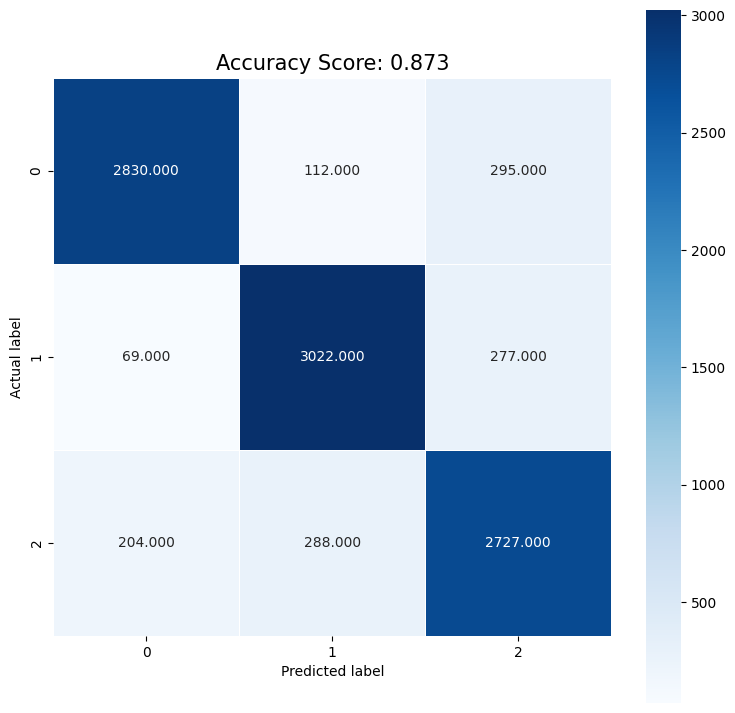

In [ ]:
confusion_1 = metrics.confusion_matrix(encoded_list_y_test, encoded_list_test_pred)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3g}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [ ]:
print(classification_report(encoded_list_y_test, encoded_list_test_pred))

              precision    recall  f1-score   support

           1       0.91      0.87      0.89      3237
           2       0.88      0.90      0.89      3368
           3       0.83      0.85      0.84      3219

    accuracy                           0.87      9824
   macro avg       0.87      0.87      0.87      9824
weighted avg       0.87      0.87      0.87      9824



In [ ]:
# Inference on custom sentences
def custom_sentence(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = DataGenerate(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    return pred, proba


In [ ]:
sentence1 = "We are standing far away"
sentence2 = "We are standing next to each other"
custom_sentence(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 3s 3s/step


('contradiction', ' 0.93%')

In [ ]:
sentence1 = "He is sitting on a chair"
sentence2 = "He is watching a movie"
custom_sentence(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 130ms/step


('neutral', ' 0.94%')

In [ ]:
sentence1 = "We are doing homework"
sentence2 = "We are working"
custom_sentence(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 118ms/step


('entailment', ' 0.96%')